# Analysis

## input data

In [1]:
from auth import sp
import pandas as pd
from utils import fetch_all_playlist_tracks

# Get user's playlists
playlists = sp.current_user_playlists()
total_playlists = len(playlists['items'])

# Get the tracks from the playlists in the "Rated" folder
tracks = []
for i, playlist in enumerate(playlists['items']):
    if playlist['name'] in ["0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", "3.5", "4.0", "4.5", "5.0"]:
        playlist_id = playlist['id']
        playlist_tracks = fetch_all_playlist_tracks(playlist_id)
        track_ids = [item['track']['id'] for item in playlist_tracks]
        
        # Get audio features for each track
        num_tracks_to_fetch = 100  # Maximum number of tracks to fetch at once
        for j in range(0, len(track_ids), num_tracks_to_fetch):
            audio_features_list = sp.audio_features(track_ids[j:j+num_tracks_to_fetch])
            
            for track, audio_features in zip(playlist_tracks[j:j+num_tracks_to_fetch], audio_features_list):
                track = track['track']
                
                # Merge track and its audio features
                track.update(audio_features)
                
                # Add rating to track
                track['rating'] = float(playlist['name'])  # Convert the playlist name to float and use it as the rating
                tracks.append(track)
    
    print(f'\rProcessed {i+1} of {total_playlists} playlists...', end='')


df = pd.DataFrame(tracks)

# Select columns to keep
columns_to_keep = [
    "album",
    "artists",
    "duration_ms",
    "explicit",
    "href",
    "id",
    "name",
    "popularity",
    "preview_url",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "track_href",
    "time_signature",
    "rating",
]
df = df[columns_to_keep]

# save tracks to csv
print('\nSaving tracks to CSV...')

# try then wait for user input if can't in order for the user to close the file if it's open
try:
    df.to_csv('rated.csv')
except PermissionError:
    input('Please close the file "rated.csv" then press enter to continue...')
    df.to_csv('rated.csv')

print(f'Done. Total number of rated songs: {len(tracks)}')

Processed 15 of 50 playlists...Fetching tracks from '1.0' by Bill
Processed 16 of 50 playlists...Fetching tracks from '1.5' by Bill
Processed 17 of 50 playlists...Fetching tracks from '5.0' by Bill
Processed 18 of 50 playlists...Fetching tracks from '2.5' by Bill
Processed 19 of 50 playlists...Fetching tracks from '2.0' by Bill
Processed 20 of 50 playlists...Fetching tracks from '0.5' by Bill
Processed 21 of 50 playlists...Fetching tracks from '3.0' by Bill
Processed 22 of 50 playlists...Fetching tracks from '4.5' by Bill
Processed 23 of 50 playlists...Fetching tracks from '4.0' by Bill
Processed 24 of 50 playlists...Fetching tracks from '3.5' by Bill
Processed 50 of 50 playlists...
Saving tracks to CSV...
Done. Total number of rated songs: 524


## output data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
try:
    tracks_df = pd.read_csv('rated.csv')
except FileNotFoundError:
    print("Error: 'rated.csv' not found.")
    exit()

# Preprocess data
tracks_df.dropna(inplace=True)  # Drop rows with missing values
tracks_df = pd.get_dummies(tracks_df)  # One-hot encode categorical data

# Define your target variable
target_column = 'rating'  # Replace this with the column that represents the rating of a track

# Split data into features (X) and target variable (y)
X = tracks_df.drop(target_column, axis=1)
y = tracks_df[target_column]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Define hyperparameters
n_estimators = 100
max_depth = 10
min_samples_split = 2

# Define and train the model with editable hyperparameters
rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=1)
rf.fit(X_train, y_train)

# Make predictions
predictions = rf.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2 Score): {r2}')


Mean Absolute Error (MAE): 0.087
Mean Squared Error (MSE): 0.1471313157894737
R-squared (R2 Score): 0.7085469435908692


## visualisations

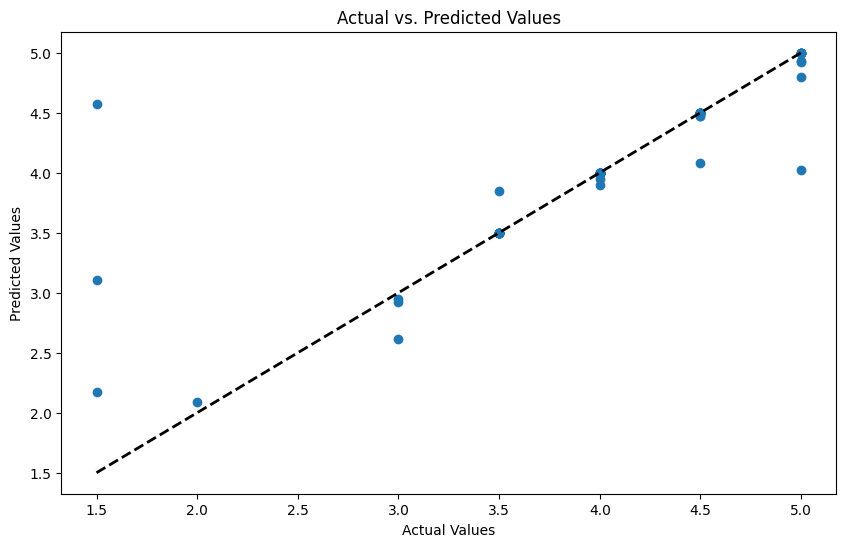

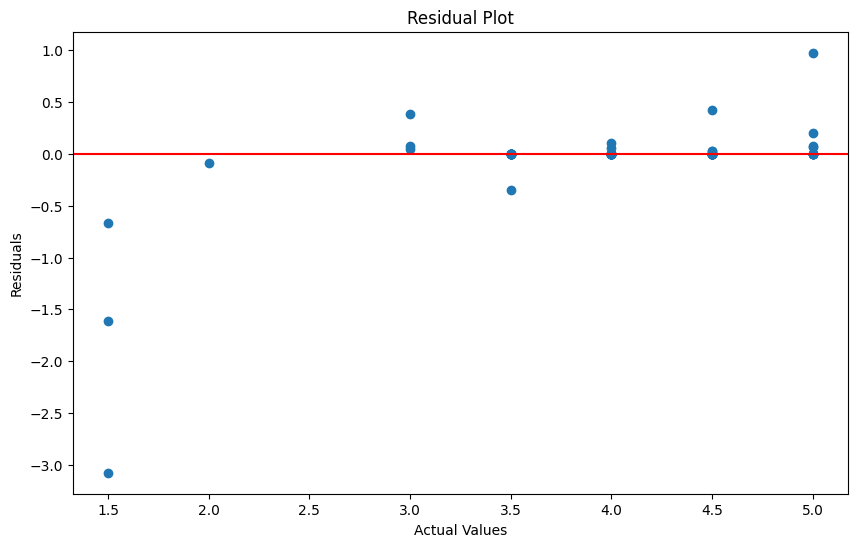

In [3]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Add y=x line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.show()

# Residual plot
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Give Recommendations to Users Based on Their Preferences

## load unrated songs

In [4]:
sources_ids = [
    "37i9dQZEVXcToZ9oox3nki",
    "37i9dQZF1DWZdLqpoFOt65",
    "37i9dQZEVXbn0l6flXloCt",
    "37i9dQZF1DWW1yuCSjnKtM",
    "22mm5J4DcucnRDLv0BAvti",
    "1h419AHuvIuFXjUjndFC25",
    "0gqrnk12Q8OExuCeKyBRCq",
    "3wXgQJZudZsz7RGyPMTQGa"
]
# discover weekly
# for you.
# release radar
# !!!
# discover weekly (cash)
# discovered weekly (trending.)
# BEST SONGS OF ALL TIME
# best tracks from the top albums of all time - RYM (RateYourMusic)

In [5]:
import os
from utils import fetch_all_playlist_tracks
from auth import sp

# Load rated songs if exists
rated_songs = pd.read_csv('rated.csv') if os.path.exists('rated.csv') and os.path.getsize('rated.csv') > 0 else pd.DataFrame()

# Load unrated songs if exists
unrated_songs = pd.read_csv('unrated.csv') if os.path.exists('unrated.csv') and os.path.getsize('unrated.csv') > 0 else pd.DataFrame()

tracks = []

for playlist_id in sources_ids:
    playlist_tracks = fetch_all_playlist_tracks(playlist_id)
    track_ids = [t['track']['id'] for t in playlist_tracks if t['track'] is not None and 'id' in t['track'] and t['track']['id'] not in rated_songs['id'].values and t['track']['id'] is not None]

    # Get audio features for each track
    for j in range(0, len(track_ids), 100):
        try:
            audio_features_list = sp.audio_features(track_ids[j:j+100])
        except Exception as e:
            print(f"Error: {e}")
            continue
        
        for track, audio_features in zip(playlist_tracks[j:j+100], audio_features_list):
            track = track['track']
            
            # Skip if the track is None or if 'id' key doesn't exist in track
            if track is None or 'id' not in track:
                continue
            
            # Skip if song is either already rated
            if 'id' in rated_songs.columns and track['id'] in rated_songs['id'].values:
                continue
            
            # Append track details and audio features to the list
            tracks.append({
                'id': track['id'],
                'name': track['name'],
                'artist': track['artists'][0]['name'],
                'album': track['album']['name'],
                'release_date': track['album']['release_date'],
                'duration_ms': track['duration_ms'],
                'popularity': track['popularity'],
                **audio_features
            })
            
print(f"\n Processed {len(tracks)} tracks")

# Convert to DataFrame and save to CSV
tracks_df = pd.DataFrame(tracks)
tracks_df.to_csv("unrated.csv", index=False)

Fetching tracks from 'Discover Weekly' by Spotify
Fetching tracks from 'for you.' by Spotify
Fetching tracks from 'Release Radar' by Spotify
Fetching tracks from '!!!' by Spotify
Fetching tracks from 'Discover Weekly' by cash
Fetching tracks from 'Discovered Weekly' by trending.
Fetching tracks from 'BEST SONGS OF ALL TIME' by Best Songs Of All Time
Fetching tracks from 'best tracks from the top albums of all time - RYM (RateYourMusic)' by Henrique Oliveira
9901 / 9901 tracks fetched
 Processed 12286 tracks


## recommend songs

In [6]:
# Set display options
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = rf.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Create Spotify link using the song's ID
unrated_songs['spotify_link'] = 'https://open.spotify.com/track/' + unrated_songs['id']

# Recommend the top 10 songs with the highest predicted ratings
recommended_songs = unrated_songs.nlargest(10, 'predicted_rating')

# Reset index and print recommended songs
recommended_songs = recommended_songs.reset_index(drop=True)

# Display the table
recommended_songs[["name", "artist", "album", "spotify_link", "predicted_rating"]]

,name,artist,album,spotify_link,predicted_rating
0,ONE CALL,Rich Amiri,Ghetto Fabulous,https://open.spotify.com/track/7jxnHknJtjE1MM8IfUidMF,2.225
1,Stairway to Heaven - Remaster,Led Zeppelin,Led Zeppelin IV (Deluxe Edition),https://open.spotify.com/track/6AS6xExH5qqqt6HMViLIdo,2.215
2,Young Folks,Peter Bjorn and John,Writer's Block,https://open.spotify.com/track/4qsHN0A1uiS4stUbDjlUbe,2.210
3,ocean eyes,Billie Eilish,dont smile at me,https://open.spotify.com/track/5PjdC2gMATetx5xdnwGUu7,2.210
4,Yesterday - Remastered 2009,The Beatles,Help! (Remastered),https://open.spotify.com/track/4qdgv45EPcQqpQ08tF34f8,2.210
5,Best Part (feat. H.E.R.),Daniel Caesar,Freudian,https://open.spotify.com/track/24vNw0Z0srb4zYXwrakw8E,2.210
6,Brain Stew,Green Day,Insomniac,https://open.spotify.com/track/0udOCZp7yk0Ml92C0k8H8D,2.210
7,Buddy Holly,Weezer,Weezer,https://open.spotify.com/track/3lecA86POu0jRaFIubASoT,2.210
8,Kiss,Prince,Parade - Music from the Motion Picture Under the Cherry Moon,https://open.spotify.com/track/2Uup75DRkJ03P91XyITXGC,2.210
9,Would That I,Hozier,"Wasteland, Baby!",https://open.spotify.com/track/2BMffjr4KyshdbZz7UAC6w,2.205


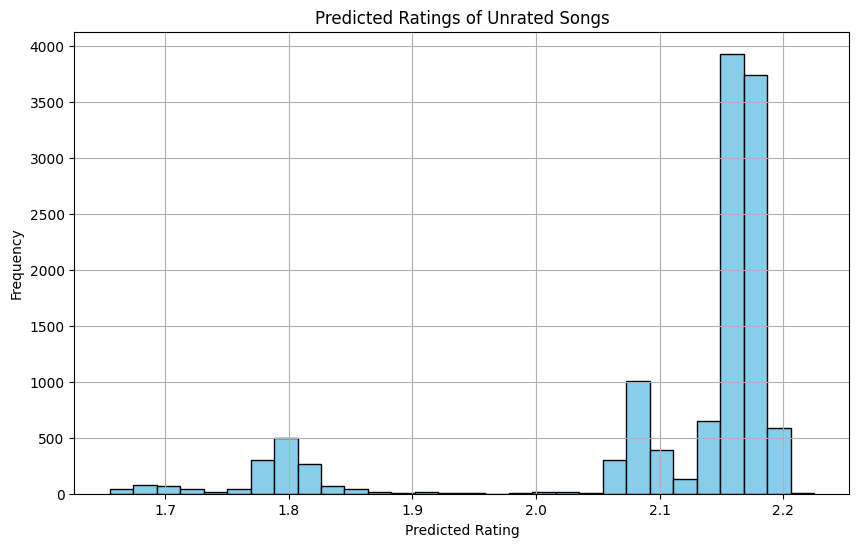

In [7]:
# Load data of unrated songs
unrated_songs = pd.read_csv('unrated.csv')

# Keep a copy of song names, artist, album, and id
song_data = unrated_songs[["name", "artist", "album", "id"]]

# Preprocess data
unrated_songs = unrated_songs.dropna()  # Drop rows with missing values
unrated_songs = pd.get_dummies(unrated_songs.drop(["name", "artist", "album", "id"], axis=1))  # One-hot encode categorical data excluding song data

# Make sure the unrated songs data has the same columns as the training data
missing_cols = set(X_train.columns) - set(unrated_songs.columns)
missing_df = pd.DataFrame(0, index=unrated_songs.index, columns=list(missing_cols))
unrated_songs = pd.concat([unrated_songs, missing_df], axis=1)
unrated_songs = unrated_songs[X_train.columns]

# Predict ratings of unrated songs
predicted_ratings = rf.predict(unrated_songs)

# Add predicted ratings and song data to unrated songs data
unrated_songs['predicted_rating'] = predicted_ratings
unrated_songs = pd.concat([unrated_songs, song_data], axis=1)

# Plot a graph of the predicted ratings
plt.figure(figsize=(10, 6))
plt.hist(unrated_songs['predicted_rating'], bins=30, color='skyblue', edgecolor='black')
plt.title('Predicted Ratings of Unrated Songs')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()